# Loading CSV Data From Prior Script

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

CSV_FILE = 'sdss_data.csv'
IMG_DIR = 'sdss_images'
IMG_SIZE = 128

df = pd.read_csv(CSV_FILE, comment = '#')
print(f'Successfully loaded {len(df)} galaxy coordinates.')
df.head()

Successfully loaded 1000 galaxy coordinates.


,objID,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroRad_r,petroRad_g,z,zErr
0,1237648704585662641,203.042941,0.014639,20.69178,18.76838,17.68217,17.18957,16.84236,3.183995,3.634754,0.152338,0.000035
1,1237648704585662865,202.931765,0.114071,23.79132,21.99652,20.40593,19.48305,19.25461,3.342154,2.969919,0.566904,0.000171
2,1237648704585662884,202.940071,0.204344,23.20472,22.23272,20.48755,19.57254,18.90709,1.881210,1.649263,0.504841,0.000155
3,1237648704585663201,203.047676,0.031271,24.53938,22.03534,20.36415,19.34721,18.97953,2.700954,2.969919,0.499408,0.000177
4,1237648704585663335,202.961607,0.062155,25.04012,23.03566,21.02226,19.88334,19.45707,2.969387,2.969919,0.616243,0.000292


# Load Images From Folder

In [87]:
from keras.utils import load_img, img_to_array

def load_images(df: pd.DataFrame, image_dir: Path) -> np.array:
    images = []

    for index, _ in df.iterrows():
        img_path = os.path.join(image_dir, f'image_{index:04d}.jpg')
        # print(f'Loading {img_path}')
        try:
            img = load_img(img_path, target_size = (IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
        except Exception as e:
            print(f'Could not load image path {img_path}: {e}')
    images = np.array(images)
    return images

In [14]:
images = load_images(df, Path('sdss_images'))
print(images.shape)
labels = df['z'].values
# print(labels)

(1000, 128, 128, 3)


# Split Image Data

In [50]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(df))
X_train_index, X_val_index, y_train, y_val = train_test_split(indices, labels, test_size = 0.25, random_state = 396)
X_train = images[X_train_index]
X_val = images[X_val_index]

# CNN Model Built and Compiled

In [52]:
import tensorflow as tf
from keras import layers
from keras.models import Sequential

def build_redshift_cnn(input_shape: np.shape) -> tf.keras.Model:
    model = Sequential(
        # Using 3 3x3 conv filters
        [
            layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape, name = 'conv1'),
            layers.MaxPooling2D((2, 2), name = 'pool1', padding = 'valid'),

            layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = input_shape, name = 'conv2'),
            layers.MaxPooling2D((2, 2), name = 'pool2', padding = 'valid'),

            layers.Conv2D(128, (3, 3), activation = 'relu', input_shape = input_shape, name = 'conv3'),
            layers.MaxPooling2D((2, 2), name = 'pool3', padding = 'valid'),

            layers.GlobalAveragePooling2D(),
            layers.Dense(32, activation = 'relu', name = 'fconn1'),
            layers.Dropout(0.5, name = 'dropout'),
            layers.Dense(1, activation = 'linear', name = 'output'),
        ]
    )
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
    return model

model = build_redshift_cnn((128, 128, 3))
print(model.summary())

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fconn1 (Dense)                  │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,409 (380.50 KB)

 Trainable params: 97,409 (380.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [53]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (750, 128, 128, 3)
y_train shape: (750,)
X_val shape: (250, 128, 128, 3)
y_val shape: (250,)


# Train Model

In [54]:
EPOCHS = 15
BATCH_SIZE = 32

def train_model(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray) -> tf.keras.Model:
    return model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = EPOCHS, batch_size = BATCH_SIZE)

hist = train_model(X_train, y_train, X_val, y_val)

Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.1153 - mean_absolute_error: 0.2641 - val_loss: 0.0570 - val_mean_absolute_error: 0.2137
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0634 - mean_absolute_error: 0.2087 - val_loss: 0.0484 - val_mean_absolute_error: 0.1940
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0625 - mean_absolute_error: 0.1976 - val_loss: 0.0463 - val_mean_absolute_error: 0.1832
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0857 - mean_absolute_error: 0.1936 - val_loss: 0.0504 - val_mean_absolute_error: 0.1895
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - loss: 0.0667 - mean_absolute_error: 0.1867 - val_loss: 0.0388 - val_mean_absolute_error: 0.1540
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0590 - mean_absolute_error: 0.1646 - val_loss: 0.0328 - val_mean_absolute_error: 0.1327
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0371 - mean_absolute_error: 0.1400 - va

# Plotted Regression Graph and Estimated Hubble's Constant

In [99]:
from sklearn.linear_model import LinearRegression

C = 299792.458
M_r = -21.0 # We assume this for now: predicted to be between -17.5 and -23.6

def regression_estimate() -> tuple:
    z_predicted_val = model.predict(X_val).flatten()

    df_val = df.iloc[X_val_index].copy()
    df_val['z_predicted'] = z_predicted_val
    df_val['velocity'] = C * df_val['z_predicted']
    df_val['distance'] = np.pow(10, (df_val['modelMag_r'] - M_r - 25) / 5)

    X = df_val[['distance']]
    y = df_val['velocity']

    reg = LinearRegression(fit_intercept = False)
    reg.fit(X, y)

    hubble_const = reg.coef_[0]
    print(f'Estimated Hubble\'s Constant: {hubble_const:.4f} km/s/Mpc')
    return (df_val, X, reg, hubble_const)

df_val, X, reg, hubble_const = regression_estimate()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Estimated Hubble's Constant: 69.1722 km/s/Mpc


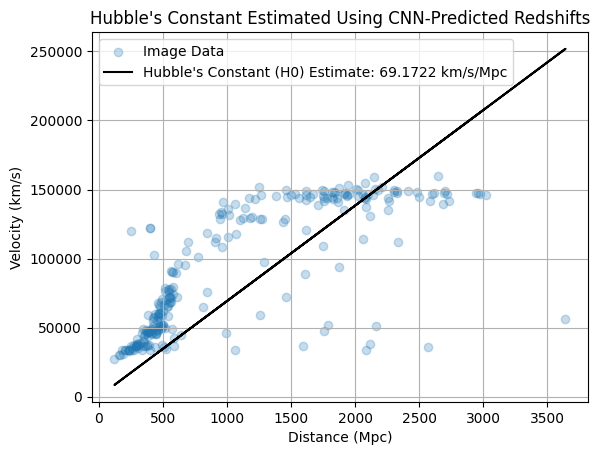

In [100]:
import matplotlib.pyplot as plt

def plot_model_data(df_val: pd.DataFrame, X: pd.DataFrame, reg: LinearRegression, hubble_const: float) -> None:
    plt.scatter(df_val['distance'], df_val['velocity'], alpha = 0.25, label = 'Image Data')
    plt.plot(df_val['distance'], reg.predict(X), color = 'black', label = f'Hubble\'s Constant (H0) Estimate: {hubble_const:.4f} km/s/Mpc')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Velocity (km/s)')
    plt.title('Hubble\'s Constant Estimated Using CNN-Predicted Redshifts')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_model_data(df_val, X, reg, hubble_const)